In [2]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools absl-py

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
BATCH_SIZE = 32
LAST_DENSE = 1024
SOFTMAX_OUT = True
FROM_LOGITS = False
LEARNING_RATE = 0.0001
INFO = "-"

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [4]:
class ResNet34:
    def __init__(self, lr=LEARNING_RATE, input_shape=(224,224,3), classes=5):
        self.input_shape = input_shape
        self.lr = lr
        self.opt = Adam(learning_rate=self.lr)
        self.classes = classes
        self.model = self.CreateModel()

    def IdentityBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same")(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        add = Add()([batchnorm2,input])
        relu2 = ReLU()(add)
        return relu2

    def ConvolutionBlock(self, input, filters):
        conv1 = Conv2D(filters, (3,3), padding="same", strides=(2,2))(input)
        batchnorm1 = BatchNormalization(axis=3)(conv1)
        relu1 = ReLU()(batchnorm1)

        conv2 = Conv2D(filters, (3,3), padding="same")(relu1)
        batchnorm2 = BatchNormalization(axis=3)(conv2)

        linear_proj = Conv2D(filters, (1,1), strides=(2,2))(input)

        add = Add()([batchnorm2, linear_proj])
        relu2 = ReLU()(add)
        return relu2

    def CreateModel(self):
        input = Input(shape=self.input_shape)
        x = ZeroPadding2D((3,3))(input)
        x = Conv2D(64, (7,7), strides=(2,2))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.IdentityBlock(x, 64)
        x = self.ConvolutionBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.IdentityBlock(x, 128)
        x = self.ConvolutionBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.IdentityBlock(x, 256)
        x = self.ConvolutionBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = self.IdentityBlock(x, 512)
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        if LAST_DENSE > 0:
            x = Dense(LAST_DENSE, activation="relu")(x)
        if SOFTMAX_OUT:
            x = Dense(self.classes, activation='softmax')(x)
        else:
            x = Dense(self.classes)(x)


        model = Model([input], x)
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=self.opt, metrics=METRICS)
        return model

resnet = ResNet34(classes=len(coco_labels))
#resnet.model.summary()
# resnet.model = tf.keras.applications.ResNet50(weights=None, classes=5, input_shape = (224,224,3))
# resnet.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])

127987
['127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '0' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '0' '127987' '127987' '127987' '0'
 '127987' '0' '127987' '127987' '127987' '127987' '0' '127987' '127987'
 '0' '127987' '127987' '127987' '127987' '127987' '127987' '127987' '0'
 '127987' '127987' '127987' '127987' '127987' '127988' '127987' '0'
 '127987' '127987' '127987' '127987' '127987' '127987' '0' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '0' '127987'
 '127987' '127987' '127987' '127987' '127987' '127987' '127987' '127987'
 '127987' '127987' '127987' '127987' '127987' '0' '127987' '127987']


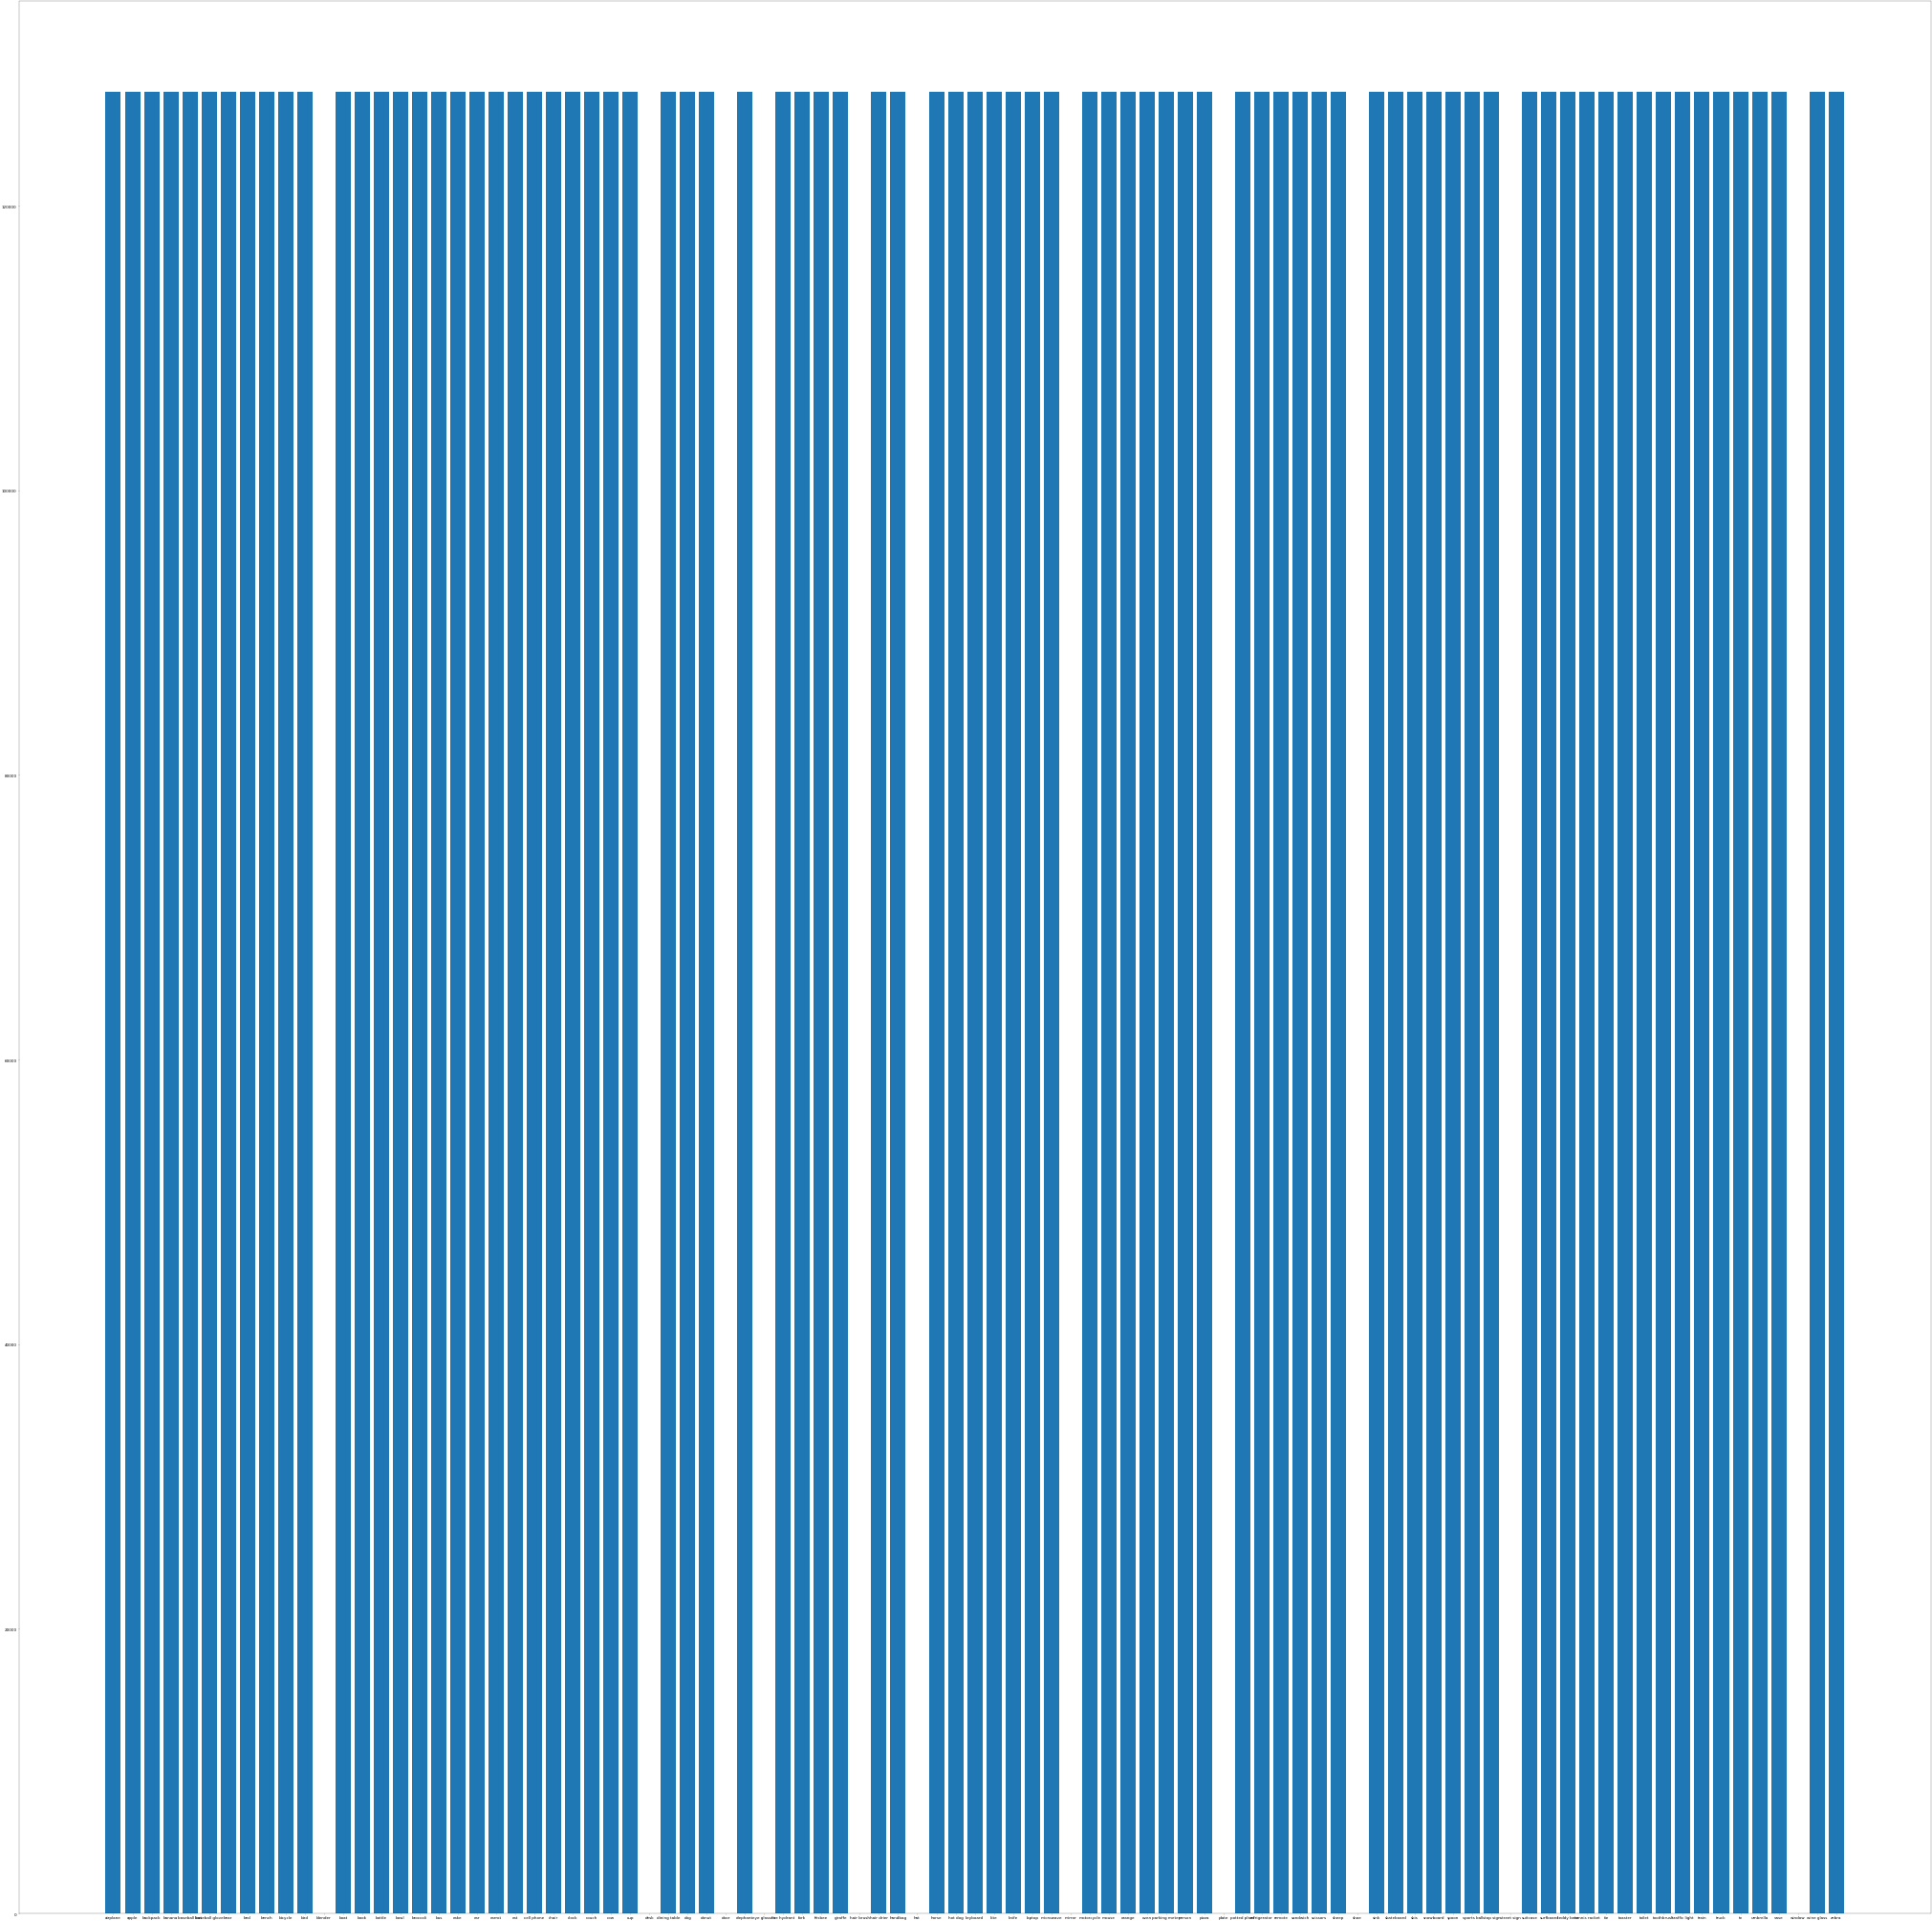

In [5]:
amounts = []
for c in os.listdir("coco_onehot_data"):
    amounts.append((c, len(os.listdir("coco_onehot_data/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 15})
fig = plt.pyplot.figure(figsize=(100,100), dpi=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

print(min({x for x in np.asarray(amounts[:,1],dtype=int) if x > 0}))
print(amounts[:,1])

In [6]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img/255
    lbl = tf.strings.split(path, os.path.sep)[-2]
    lbl = lbl == coco_labels
    return img, tf.one_hot(tf.argmax(lbl), len(coco_labels))

tf_dataset = tf.data.Dataset.list_files('coco_onehot_data/*/*')

AUTOTUNE = tf.data.AUTOTUNE

val_size = int(len(tf_dataset)*0.1)
train_ds = tf_dataset.skip(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = tf_dataset.take(val_size).map(load_images, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

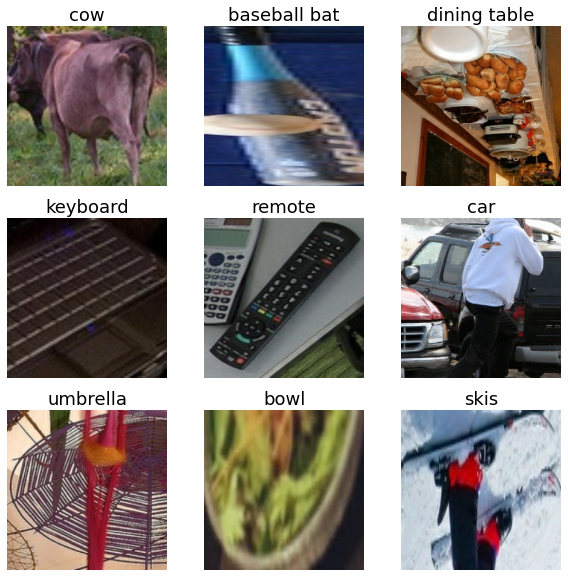

In [7]:
img_batch, lbl_batch = next(iter(train_ds))

plt.pyplot.figure(figsize=(10,10))
for i in range(9):
    ax = plt.pyplot.subplot(3,3,i+1)
    plt.pyplot.imshow(img_batch[i].numpy().astype("float32"))
    label = lbl_batch[i].numpy()
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels[label])
    plt.pyplot.axis("off")

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet34

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet34/{0}'.format(current_time)
weight_dir = 'weights/resnet34/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_freq=100)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 158792), started 0:08:15 ago. (Use '!kill 158792' to kill it.)

In [13]:
def train(EPOCHS):
    print("Starting training...")
        
    with summary_writer.as_default():
        tf.summary.text('configuration', CONFIG_STRING.format(BATCH_SIZE, LAST_DENSE, SOFTMAX_OUT, FROM_LOGITS, LEARNING_RATE, INFO), step=1)

    hist_train = resnet.model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=[tensorboard_callback, weight_callback], epochs=EPOCHS)

train(10)

Starting training...
Epoch 1/10
    99/287971 [..............................] - ETA: 71:46:57 - loss: 4.0543 - tp: 14.0000 - fp: 31.0000 - tn: 285089.0000 - fn: 3154.0000 - accuracy: 0.0660 - precision: 0.3111 - recall: 0.0044 - auc: 0.7469 - prc: 0.0415INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


   100/287971 [..............................] - ETA: 103:07:48 - loss: 4.0533 - tp: 14.0000 - fp: 31.0000 - tn: 287969.0000 - fn: 3186.0000 - accuracy: 0.0653 - precision: 0.3111 - recall: 0.0044 - auc: 0.7473 - prc: 0.0415

f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   199/287971 [..............................] - ETA: 87:59:54 - loss: 4.0085 - tp: 42.0000 - fp: 75.0000 - tn: 573045.0000 - fn: 6326.0000 - accuracy: 0.0758 - precision: 0.3590 - recall: 0.0066 - auc: 0.7550 - prc: 0.0479INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   299/287971 [..............................] - ETA: 86:55:52 - loss: 3.9868 - tp: 60.0000 - fp: 105.0000 - tn: 861015.0000 - fn: 9508.0000 - accuracy: 0.0788 - precision: 0.3636 - recall: 0.0063 - auc: 0.7597 - prc: 0.0500INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   399/287971 [..............................] - ETA: 85:40:07 - loss: 3.9561 - tp: 100.0000 - fp: 139.0000 - tn: 1148981.0000 - fn: 12668.0000 - accuracy: 0.0843 - precision: 0.4184 - recall: 0.0078 - auc: 0.7662 - prc: 0.0542INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   499/287971 [..............................] - ETA: 83:27:34 - loss: 3.9211 - tp: 142.0000 - fp: 175.0000 - tn: 1436945.0000 - fn: 15826.0000 - accuracy: 0.0881 - precision: 0.4479 - recall: 0.0089 - auc: 0.7728 - prc: 0.0583INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   599/287971 [..............................] - ETA: 81:38:22 - loss: 3.8935 - tp: 190.0000 - fp: 210.0000 - tn: 1724910.0000 - fn: 18978.0000 - accuracy: 0.0913 - precision: 0.4750 - recall: 0.0099 - auc: 0.7780 - prc: 0.0622INFO:tensorflow:Assets written to: weights/resnet34\20220312-123454\assets


f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
f:\KOULU\opparii\Projekti\.venv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


   699/287971 [..............................] - ETA: 80:58:56 - loss: 3.8665 - tp: 239.0000 - fp: 241.0000 - tn: 2012879.0000 - fn: 22129.0000 - accuracy: 0.0949 - precision: 0.4979 - recall: 0.0107 - auc: 0.7829 - prc: 0.0656

KeyboardInterrupt: 

In [10]:
resnet.model.save_weights(os.path.join(weight_dir, weight_file.format("_onehot")))

In [12]:

resnet.model.evaluate(validation_ds, verbose=1)


14/14 [==============================] - 2s 151ms/step - loss: 2.2457 - accuracy: 0.6529


[2.2457149028778076, 0.6528735756874084]